<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20K-NN%20-%20LSTM%20for%204%20class%20classifications%20based%20on%20WSNBFSF%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid K-NN - LSTM for 4 class classifications based on WSNBFSF dataset**

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score

In [4]:
# Load the dataset
dataset = pd.read_csv("dataset.csv")
dataset.shape
dataset.isnull().sum()
dataset.info()
dataset["Class"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312106 entries, 0 to 312105
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           312106 non-null  int64  
 1   Time            312106 non-null  float64
 2   S_Node          312106 non-null  int64  
 3   Node_id         312106 non-null  int64  
 4   Rest_Energy     312106 non-null  float64
 5   Trace_Level     312106 non-null  int64  
 6   Mac_Type_Pckt   312106 non-null  int64  
 7   Source_IP_Port  312106 non-null  float64
 8   Des_IP_Port     312106 non-null  float64
 9   Packet_Size     312106 non-null  int64  
 10  TTL             312106 non-null  int64  
 11  Hop_Count       312106 non-null  int64  
 12  Broadcast_ID    312106 non-null  int64  
 13  Dest_Node_Num   312106 non-null  int64  
 14  Dest_Seq_Num    312106 non-null  int64  
 15  Src_Node_ID     312106 non-null  int64  
 16  Src_Seq_Num     312106 non-null  int64  
 17  Class     

array([0, 1, 2, 3])

**Data preprocessing**

In [5]:
# Data preprocessing
y = dataset['Class'].values
X = dataset.drop(['Class'], axis=1)
X = X.values

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Data balancing using SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [9]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**K-NN Model**

In [10]:
# Train the K-NN classifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Obtain predictions from the K-NN classifier
knn_pred = knn_model.predict(X_test)

In [14]:
##from sklearn.preprocessing import StandardScaler
    # Standardize the features
##scaler = StandardScaler()
##X_train = scaler.fit_transform(X_train)
##X_test = scaler.transform(X_test)

In [19]:
    # Reshape the data for LSTM
##X = X.reshape(X.shape[0], X.shape[1], 1)

**LSTM Model**

In [22]:
from keras.utils import to_categorical
# Reshape the input data for LSTM (assuming you want to consider a single feature)
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert class labels to categorical representation
num_classes = len(np.unique(y))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Train the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(num_classes, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_categorical, epochs=10, batch_size=64)

# Obtain predictions from the LSTM model
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)

Epoch 1/10
13143/13143 [==============================] - 210s 16ms/step - loss: 0.2813 - accuracy: 0.8876
Epoch 2/10
13143/13143 [==============================] - 205s 16ms/step - loss: 0.1633 - accuracy: 0.9377
Epoch 3/10
13143/13143 [==============================] - 202s 15ms/step - loss: 0.1341 - accuracy: 0.9510
Epoch 4/10
13143/13143 [==============================] - 206s 16ms/step - loss: 0.1168 - accuracy: 0.9585
Epoch 5/10
13143/13143 [==============================] - 206s 16ms/step - loss: 0.1030 - accuracy: 0.9642
Epoch 6/10
13143/13143 [==============================] - 200s 15ms/step - loss: 0.0918 - accuracy: 0.9685
Epoch 7/10
13143/13143 [==============================] - 201s 15ms/step - loss: 0.0818 - accuracy: 0.9721
Epoch 8/10
13143/13143 [==============================] - 200s 15ms/step - loss: 0.0735 - accuracy: 0.9750
Epoch 9/10
13143/13143 [==============================] - 201s 15ms/step - loss: 0.0678 - accuracy: 0.9773
Epoch 10/10
6572/6572 [==============

In [23]:
# Combine predictions from K-NN and LSTM models
hybrid_pred = np.where(knn_pred == lstm_pred, knn_pred, -1)  # Replace non-matching predictions with -1

# Final prediction using the majority vote
final_pred = np.where(hybrid_pred == -1, knn_pred, hybrid_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, final_pred)
print("Hybrid Model Accuracy:", accuracy)

Hybrid Model Accuracy: 0.9870459052410822


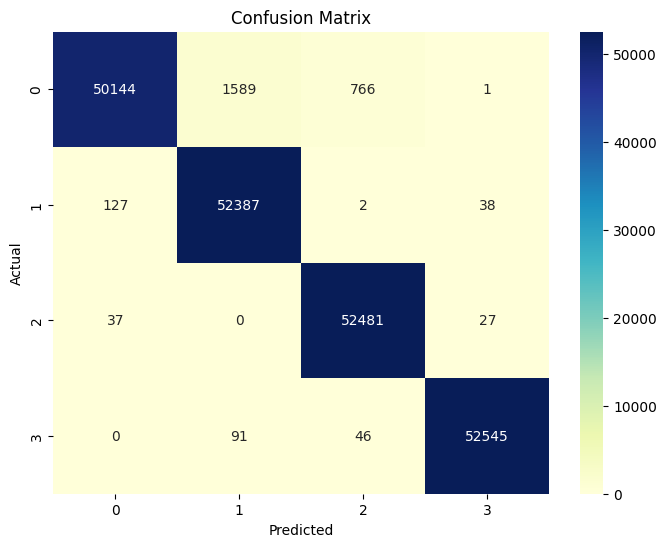

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, final_pred)

# Get the class labels
class_labels = np.unique(y_test)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='YlGnBu')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

In [30]:
print("Confusion Matrix of Hybrid RF-RNN Model") 
confusion_matrix(y_test, final_pred)

Confusion Matrix of Hybrid RF-RNN Model


array([[50144,  1589,   766,     1],
       [  127, 52387,     2,    38],
       [   37,     0, 52481,    27],
       [    0,    91,    46, 52545]])